In [1]:
import numpy as np
import pickle
from pandas import DataFrame, read_csv
from sklearn import preprocessing
from sklearn import metrics as met
import warnings
import tensorflow as tf
from tensorflow.contrib import rnn
import helperModule as hm
import matplotlib.pyplot as plt
from tensorflow import nn
from matplotlib import gridspec


warnings.filterwarnings("ignore")
%config InlineBackend.figure_format = 'retina'



In [38]:
#########################
############ Hyperparamter
#########################

st_dev = 0.1
learning_rate = 0.001
training_iters = 26000000
batch_size = 64
display_step = 100

n_input = 41 # Number of features
n_steps = 1 # timesteps
n_hidden = 512 # hidden layer num of nodes
n_classes = 5 # KDD99 total classes ( Normal + 4 attack types)


In [3]:
#########################
############ Read in data
#########################

data = pickle.load( open( "kdd99.p", "rb" ) )

x_train = data['x_train']
x_test = data['x_test']
y_train = data['y_train']
y_test = data['y_test']


In [23]:
## Create input placeholders and weights

tf.reset_default_graph()

tf.set_random_seed(0.5)

# tf Graph input
x = tf.placeholder("float", [None, n_steps, n_input])
y = tf.placeholder("float", [None, n_classes])
#keep_prob = tf.placeholder(tf.float32, name='keep_prob')

# Define weights
W = {
    'out': tf.Variable(tf.truncated_normal([n_hidden, n_classes], stddev=st_dev, seed=0.5))
}

b = {
    'out': tf.Variable(tf.zeros([n_classes]))
}

In [24]:
def RNN(x, W, b):

    # Current data input shape: (batch_size, n_steps, n_input)
    # Required shape: 'n_steps' tensors list of shape (batch_size, n_input)

    # Unstack to get a list of 'n_steps' tensors of shape (batch_size, n_input)
    x = tf.unstack(x, n_steps, 1)

    # Define a lstm cell with tensorflow
    lstm_cell = tf.contrib.rnn.LSTMCell(n_hidden, state_is_tuple = True)
        
    # Get lstm cell output
    output, states = tf.nn.static_rnn(lstm_cell, x, dtype=tf.float32)

    # Linear activation, using rnn inner loop last output
    return tf.matmul(output[-1], W['out']) + b['out']

In [25]:

pred = RNN(x, W, b)

# Define loss and optimizer
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=pred, labels=y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

# Evaluate model
correct_pred = tf.equal(tf.argmax(pred,1), tf.argmax(y,1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

# Initializing the variables
init = tf.global_variables_initializer()

In [39]:
# Launch the graph
with tf.Session() as sess:

    sess.run(init)
    step = 1
    losses = {'train':[], 'validation':[]}
    # Keep training until reach max iterations
    while step * batch_size < training_iters:
        offset = (step * batch_size) % (y_train.shape[0] - batch_size)
        offset_test = (step * batch_size) % (y_test.shape[0] - batch_size)
        
        # Generate minibatches for training and validating.
        batch_x = x_train[offset:(offset + batch_size), :]
        batch_y = y_train[offset:(offset + batch_size), :]
        batch_test_x = x_test[offset_test:(offset_test + batch_size), :]
        batch_test_y = y_test[offset_test:(offset_test + batch_size), :]
        
        # Reshape data to feed into RNN
        batch_x = batch_x.reshape((batch_size, n_steps, n_input))
        batch_test_x = batch_test_x.reshape((batch_size, n_steps, n_input))
        
        # Run optimization op (backprop)
        sess.run(optimizer, feed_dict={x: batch_x, y: batch_y})
        loss = sess.run(cost, feed_dict={x: batch_x, y: batch_y})
        loss_test = sess.run(cost, feed_dict={x: batch_test_x, y: batch_test_y})

        if step % display_step == 0:

            print "Iter " + str(step*batch_size) + ", Minibatch Loss= " + "{:.6f}".format(loss) +  ", Minibatch Val Accuracy= " + \
                  "{:.6f}".format(loss_test)
                        
        losses['train'].append(loss)
        losses['validation'].append(loss_test)
        step += 1
            
    print("Optimization Finished!")

    # Generate confusion matrix for metrics computation
    y_pred = sess.run(tf.argmax(pred, 1), feed_dict={x:x_test.reshape((-1, n_steps, n_input))})
    y_true = np.argmax(y_test,1)
    conf_matrix = met.confusion_matrix(y_true, y_pred)
    
    

Iter 6400, Minibatch Loss= 0.003568, Minibatch Val Accuracy= 8.918588
Iter 12800, Minibatch Loss= 0.286244, Minibatch Val Accuracy= 0.151071
Iter 19200, Minibatch Loss= 0.004251, Minibatch Val Accuracy= 0.785382
Iter 25600, Minibatch Loss= 0.009384, Minibatch Val Accuracy= 0.702237
Iter 32000, Minibatch Loss= 0.004355, Minibatch Val Accuracy= 0.980836
Iter 38400, Minibatch Loss= 0.001661, Minibatch Val Accuracy= 0.754469
Iter 44800, Minibatch Loss= 0.095528, Minibatch Val Accuracy= 0.095745
Iter 51200, Minibatch Loss= 0.395162, Minibatch Val Accuracy= 0.006079
Iter 57600, Minibatch Loss= 0.002923, Minibatch Val Accuracy= 0.019366
Iter 64000, Minibatch Loss= 0.001248, Minibatch Val Accuracy= 0.016589
Iter 70400, Minibatch Loss= 0.001062, Minibatch Val Accuracy= 0.015092
Iter 76800, Minibatch Loss= 0.152416, Minibatch Val Accuracy= 0.257354
Iter 83200, Minibatch Loss= 0.023600, Minibatch Val Accuracy= 0.389837
Iter 89600, Minibatch Loss= 0.013500, Minibatch Val Accuracy= 0.137363
Iter 96

Iter 736000, Minibatch Loss= 0.000024, Minibatch Val Accuracy= 1.396191
Iter 742400, Minibatch Loss= 0.000023, Minibatch Val Accuracy= 1.394672
Iter 748800, Minibatch Loss= 0.000022, Minibatch Val Accuracy= 4.521178
Iter 755200, Minibatch Loss= 0.000021, Minibatch Val Accuracy= 0.655921
Iter 761600, Minibatch Loss= 0.000020, Minibatch Val Accuracy= 2.640905
Iter 768000, Minibatch Loss= 0.000019, Minibatch Val Accuracy= 0.035175
Iter 774400, Minibatch Loss= 0.000019, Minibatch Val Accuracy= 3.172002
Iter 780800, Minibatch Loss= 0.000018, Minibatch Val Accuracy= 1.336339
Iter 787200, Minibatch Loss= 0.000017, Minibatch Val Accuracy= 1.346249
Iter 793600, Minibatch Loss= 0.000016, Minibatch Val Accuracy= 1.331652
Iter 800000, Minibatch Loss= 0.000016, Minibatch Val Accuracy= 0.197838
Iter 806400, Minibatch Loss= 0.000015, Minibatch Val Accuracy= 0.166911
Iter 812800, Minibatch Loss= 0.000014, Minibatch Val Accuracy= 0.122929
Iter 819200, Minibatch Loss= 0.000014, Minibatch Val Accuracy= 0

Iter 1459200, Minibatch Loss= 0.000095, Minibatch Val Accuracy= 0.000065
Iter 1465600, Minibatch Loss= 0.000020, Minibatch Val Accuracy= 0.000062
Iter 1472000, Minibatch Loss= 0.008218, Minibatch Val Accuracy= 5.679417
Iter 1478400, Minibatch Loss= 0.000003, Minibatch Val Accuracy= 0.000003
Iter 1484800, Minibatch Loss= 0.000839, Minibatch Val Accuracy= 0.000008
Iter 1491200, Minibatch Loss= 0.000359, Minibatch Val Accuracy= 0.000003
Iter 1497600, Minibatch Loss= 0.031023, Minibatch Val Accuracy= 0.000004
Iter 1504000, Minibatch Loss= 0.000512, Minibatch Val Accuracy= 0.000004
Iter 1510400, Minibatch Loss= 0.000219, Minibatch Val Accuracy= 0.000024
Iter 1516800, Minibatch Loss= 0.000167, Minibatch Val Accuracy= 0.000031
Iter 1523200, Minibatch Loss= 0.859331, Minibatch Val Accuracy= 0.000001
Iter 1529600, Minibatch Loss= 0.002487, Minibatch Val Accuracy= 1.989667
Iter 1536000, Minibatch Loss= 0.001487, Minibatch Val Accuracy= 2.969692
Iter 1542400, Minibatch Loss= 0.000565, Minibatch V

Iter 2182400, Minibatch Loss= 0.000002, Minibatch Val Accuracy= 0.000002
Iter 2188800, Minibatch Loss= 0.000002, Minibatch Val Accuracy= 0.000002
Iter 2195200, Minibatch Loss= 0.000002, Minibatch Val Accuracy= 0.000002
Iter 2201600, Minibatch Loss= 0.000002, Minibatch Val Accuracy= 0.000002
Iter 2208000, Minibatch Loss= 0.000002, Minibatch Val Accuracy= 0.000002
Iter 2214400, Minibatch Loss= 0.000002, Minibatch Val Accuracy= 0.270344
Iter 2220800, Minibatch Loss= 0.000002, Minibatch Val Accuracy= 0.000002
Iter 2227200, Minibatch Loss= 0.000002, Minibatch Val Accuracy= 0.000002
Iter 2233600, Minibatch Loss= 0.000002, Minibatch Val Accuracy= 0.000002
Iter 2240000, Minibatch Loss= 0.000002, Minibatch Val Accuracy= 0.000002
Iter 2246400, Minibatch Loss= 0.000002, Minibatch Val Accuracy= 0.000002
Iter 2252800, Minibatch Loss= 0.000002, Minibatch Val Accuracy= 1.195392
Iter 2259200, Minibatch Loss= 0.000002, Minibatch Val Accuracy= 1.155566
Iter 2265600, Minibatch Loss= 0.000002, Minibatch V

Iter 2905600, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 0.195653
Iter 2912000, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 0.113936
Iter 2918400, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 0.115938
Iter 2924800, Minibatch Loss= 0.003096, Minibatch Val Accuracy= 8.157209
Iter 2931200, Minibatch Loss= 0.000042, Minibatch Val Accuracy= 8.184486
Iter 2937600, Minibatch Loss= 0.000021, Minibatch Val Accuracy= 8.343636
Iter 2944000, Minibatch Loss= 0.000043, Minibatch Val Accuracy= 0.000275
Iter 2950400, Minibatch Loss= 0.002761, Minibatch Val Accuracy= 0.002335
Iter 2956800, Minibatch Loss= 0.004920, Minibatch Val Accuracy= 0.000185
Iter 2963200, Minibatch Loss= 0.002423, Minibatch Val Accuracy= 0.000088
Iter 2969600, Minibatch Loss= 0.000697, Minibatch Val Accuracy= 0.000095
Iter 2976000, Minibatch Loss= 0.000822, Minibatch Val Accuracy= 0.000133
Iter 2982400, Minibatch Loss= 0.000509, Minibatch Val Accuracy= 0.242053
Iter 2988800, Minibatch Loss= 0.000393, Minibatch V

Iter 3628800, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 0.006885
Iter 3635200, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 0.022318
Iter 3641600, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 0.000000
Iter 3648000, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 0.016802
Iter 3654400, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 0.000000
Iter 3660800, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 0.000000
Iter 3667200, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 0.000002
Iter 3673600, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 0.000000
Iter 3680000, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 0.000000
Iter 3686400, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 0.000000
Iter 3692800, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 0.000000
Iter 3699200, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 0.000000
Iter 3705600, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 2.752902
Iter 3712000, Minibatch Loss= 0.000000, Minibatch V

Iter 4352000, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 2.558766
Iter 4358400, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 0.000000
Iter 4364800, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 0.000000
Iter 4371200, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 0.000000
Iter 4377600, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 0.000000
Iter 4384000, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 0.000000
Iter 4390400, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 1.494139
Iter 4396800, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 0.000000
Iter 4403200, Minibatch Loss= 0.000252, Minibatch Val Accuracy= 0.000000
Iter 4409600, Minibatch Loss= 0.000056, Minibatch Val Accuracy= 0.000000
Iter 4416000, Minibatch Loss= 0.000008, Minibatch Val Accuracy= 0.000000
Iter 4422400, Minibatch Loss= 0.000009, Minibatch Val Accuracy= 0.000000
Iter 4428800, Minibatch Loss= 0.000001, Minibatch Val Accuracy= 0.000048
Iter 4435200, Minibatch Loss= 0.018728, Minibatch V

Iter 5075200, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 0.590738
Iter 5081600, Minibatch Loss= 0.513432, Minibatch Val Accuracy= 0.002605
Iter 5088000, Minibatch Loss= 0.004122, Minibatch Val Accuracy= 0.003984
Iter 5094400, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 0.005826
Iter 5100800, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 5.870745
Iter 5107200, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 5.181742
Iter 5113600, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 4.104732
Iter 5120000, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 3.774175
Iter 5126400, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 0.004912
Iter 5132800, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 0.042858
Iter 5139200, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 0.006108
Iter 5145600, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 0.024116
Iter 5152000, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 0.024584
Iter 5158400, Minibatch Loss= 0.000000, Minibatch V

Iter 5798400, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 0.000757
Iter 5804800, Minibatch Loss= 0.009015, Minibatch Val Accuracy= 0.000243
Iter 5811200, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 0.001918
Iter 5817600, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 0.000000
Iter 5824000, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 0.008498
Iter 5830400, Minibatch Loss= 0.003702, Minibatch Val Accuracy= 3.510585
Iter 5836800, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 0.000000
Iter 5843200, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 0.000000
Iter 5849600, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 0.000000
Iter 5856000, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 0.000000
Iter 5862400, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 0.000000
Iter 5868800, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 0.000000
Iter 5875200, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 0.000000
Iter 5881600, Minibatch Loss= 0.000000, Minibatch V

Iter 6521600, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 0.000005
Iter 6528000, Minibatch Loss= 0.000272, Minibatch Val Accuracy= 0.000347
Iter 6534400, Minibatch Loss= 0.000007, Minibatch Val Accuracy= 0.000000
Iter 6540800, Minibatch Loss= 0.000005, Minibatch Val Accuracy= 0.000000
Iter 6547200, Minibatch Loss= 0.000001, Minibatch Val Accuracy= 0.000000
Iter 6553600, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 0.000000
Iter 6560000, Minibatch Loss= 0.001036, Minibatch Val Accuracy= 0.000000
Iter 6566400, Minibatch Loss= 0.083224, Minibatch Val Accuracy= 1.816984
Iter 6572800, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 0.000000
Iter 6579200, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 0.000000
Iter 6585600, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 0.000000
Iter 6592000, Minibatch Loss= 0.000001, Minibatch Val Accuracy= 0.000000
Iter 6598400, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 0.000000
Iter 6604800, Minibatch Loss= 0.000000, Minibatch V

Iter 7244800, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 0.943133
Iter 7251200, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 0.639961
Iter 7257600, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 0.005668
Iter 7264000, Minibatch Loss= 0.000089, Minibatch Val Accuracy= 0.002619
Iter 7270400, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 0.001483
Iter 7276800, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 2.054807
Iter 7283200, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 4.163816
Iter 7289600, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 3.245562
Iter 7296000, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 7.988027
Iter 7302400, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 0.004741
Iter 7308800, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 0.003283
Iter 7315200, Minibatch Loss= 0.000003, Minibatch Val Accuracy= 0.000203
Iter 7321600, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 0.000206
Iter 7328000, Minibatch Loss= 0.000000, Minibatch V

Iter 7968000, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 0.000048
Iter 7974400, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 0.000030
Iter 7980800, Minibatch Loss= 0.033765, Minibatch Val Accuracy= 0.000044
Iter 7987200, Minibatch Loss= 0.000753, Minibatch Val Accuracy= 0.001162
Iter 7993600, Minibatch Loss= 0.000310, Minibatch Val Accuracy= 0.000000
Iter 8000000, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 0.001812
Iter 8006400, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 4.136689
Iter 8012800, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 0.000000
Iter 8019200, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 0.000000
Iter 8025600, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 0.000000
Iter 8032000, Minibatch Loss= 0.066199, Minibatch Val Accuracy= 0.000000
Iter 8038400, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 0.000000
Iter 8044800, Minibatch Loss= 0.371634, Minibatch Val Accuracy= 0.000000
Iter 8051200, Minibatch Loss= 0.530421, Minibatch V

Iter 8691200, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 0.000000
Iter 8697600, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 0.000000
Iter 8704000, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 0.000000
Iter 8710400, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 0.000000
Iter 8716800, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 0.000000
Iter 8723200, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 0.000000
Iter 8729600, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 0.000000
Iter 8736000, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 0.000000
Iter 8742400, Minibatch Loss= 0.000973, Minibatch Val Accuracy= 0.158143
Iter 8748800, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 3.545275
Iter 8755200, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 0.000000
Iter 8761600, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 0.000000
Iter 8768000, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 0.000000
Iter 8774400, Minibatch Loss= 0.000000, Minibatch V

Iter 9414400, Minibatch Loss= 0.000005, Minibatch Val Accuracy= 0.000000
Iter 9420800, Minibatch Loss= 0.000435, Minibatch Val Accuracy= 1.774344
Iter 9427200, Minibatch Loss= 0.384107, Minibatch Val Accuracy= 2.809779
Iter 9433600, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 0.000001
Iter 9440000, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 0.000063
Iter 9446400, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 0.000077
Iter 9452800, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 1.495220
Iter 9459200, Minibatch Loss= 0.084359, Minibatch Val Accuracy= 3.867649
Iter 9465600, Minibatch Loss= 0.004030, Minibatch Val Accuracy= 1.858538
Iter 9472000, Minibatch Loss= 0.000182, Minibatch Val Accuracy= 10.682119
Iter 9478400, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 0.000340
Iter 9484800, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 0.222221
Iter 9491200, Minibatch Loss= 0.000629, Minibatch Val Accuracy= 0.000090
Iter 9497600, Minibatch Loss= 0.000000, Minibatch 

Iter 10131200, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 0.000044
Iter 10137600, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 0.000012
Iter 10144000, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 0.000009
Iter 10150400, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 0.000005
Iter 10156800, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 0.000002
Iter 10163200, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 0.001153
Iter 10169600, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 0.000000
Iter 10176000, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 0.000000
Iter 10182400, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 3.694117
Iter 10188800, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 0.000000
Iter 10195200, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 0.000000
Iter 10201600, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 0.000000
Iter 10208000, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 0.000000
Iter 10214400, Minibatch Loss= 0.00000

Iter 10841600, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 0.000000
Iter 10848000, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 0.000000
Iter 10854400, Minibatch Loss= 0.002774, Minibatch Val Accuracy= 0.000000
Iter 10860800, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 1.952571
Iter 10867200, Minibatch Loss= 0.000073, Minibatch Val Accuracy= 0.000000
Iter 10873600, Minibatch Loss= 0.006023, Minibatch Val Accuracy= 0.000000
Iter 10880000, Minibatch Loss= 0.000010, Minibatch Val Accuracy= 0.000000
Iter 10886400, Minibatch Loss= 0.010399, Minibatch Val Accuracy= 0.000000
Iter 10892800, Minibatch Loss= 0.005185, Minibatch Val Accuracy= 0.000000
Iter 10899200, Minibatch Loss= 0.000041, Minibatch Val Accuracy= 0.000000
Iter 10905600, Minibatch Loss= 0.000005, Minibatch Val Accuracy= 0.000000
Iter 10912000, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 0.000000
Iter 10918400, Minibatch Loss= 0.064441, Minibatch Val Accuracy= 5.663921
Iter 10924800, Minibatch Loss= 0.00000

Iter 11552000, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 0.000000
Iter 11558400, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 0.000000
Iter 11564800, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 0.000000
Iter 11571200, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 0.000000
Iter 11577600, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 0.000000
Iter 11584000, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 0.566577
Iter 11590400, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 0.000000
Iter 11596800, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 1.292029
Iter 11603200, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 4.945340
Iter 11609600, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 0.000032
Iter 11616000, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 0.000029
Iter 11622400, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 0.000024
Iter 11628800, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 2.398103
Iter 11635200, Minibatch Loss= 0.00000

Iter 12262400, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 0.690289
Iter 12268800, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 7.458816
Iter 12275200, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 0.001562
Iter 12281600, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 0.080523
Iter 12288000, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 0.000063
Iter 12294400, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 0.000065
Iter 12300800, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 0.000007
Iter 12307200, Minibatch Loss= 0.072028, Minibatch Val Accuracy= 0.000001
Iter 12313600, Minibatch Loss= 0.000041, Minibatch Val Accuracy= 0.000004
Iter 12320000, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 0.000003
Iter 12326400, Minibatch Loss= 0.000016, Minibatch Val Accuracy= 0.000006
Iter 12332800, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 0.000001
Iter 12339200, Minibatch Loss= 0.060343, Minibatch Val Accuracy= 0.001672
Iter 12345600, Minibatch Loss= 0.00000

Iter 12972800, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 0.000000
Iter 12979200, Minibatch Loss= 0.000266, Minibatch Val Accuracy= 0.000059
Iter 12985600, Minibatch Loss= 0.000934, Minibatch Val Accuracy= 0.000000
Iter 12992000, Minibatch Loss= 0.010977, Minibatch Val Accuracy= 0.000000
Iter 12998400, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 0.000000
Iter 13004800, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 0.000000
Iter 13011200, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 0.000000
Iter 13017600, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 0.000000
Iter 13024000, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 0.000000
Iter 13030400, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 0.000000
Iter 13036800, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 2.741819
Iter 13043200, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 0.000000
Iter 13049600, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 0.000000
Iter 13056000, Minibatch Loss= 0.00000

Iter 13683200, Minibatch Loss= 0.003921, Minibatch Val Accuracy= 2.977950
Iter 13689600, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 0.000000
Iter 13696000, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 0.000000
Iter 13702400, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 0.000000
Iter 13708800, Minibatch Loss= 0.000281, Minibatch Val Accuracy= 0.000000
Iter 13715200, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 0.000000
Iter 13721600, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 2.387285
Iter 13728000, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 0.000000
Iter 13734400, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 0.000000
Iter 13740800, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 0.000000
Iter 13747200, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 0.000000
Iter 13753600, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 0.000000
Iter 13760000, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 0.186091
Iter 13766400, Minibatch Loss= 0.00000

Iter 14393600, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 0.000000
Iter 14400000, Minibatch Loss= 0.000807, Minibatch Val Accuracy= 3.598226
Iter 14406400, Minibatch Loss= 0.000005, Minibatch Val Accuracy= 3.905407
Iter 14412800, Minibatch Loss= 0.000005, Minibatch Val Accuracy= 0.000000
Iter 14419200, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 0.000000
Iter 14425600, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 0.000000
Iter 14432000, Minibatch Loss= 0.003160, Minibatch Val Accuracy= 15.462401
Iter 14438400, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 6.849375
Iter 14444800, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 10.968249
Iter 14451200, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 0.000023
Iter 14457600, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 0.000006
Iter 14464000, Minibatch Loss= 0.000006, Minibatch Val Accuracy= 0.000000
Iter 14470400, Minibatch Loss= 0.000809, Minibatch Val Accuracy= 0.000024
Iter 14476800, Minibatch Loss= 0.000

Iter 15104000, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 0.000058
Iter 15110400, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 0.000000
Iter 15116800, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 0.000000
Iter 15123200, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 0.000000
Iter 15129600, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 0.000000
Iter 15136000, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 0.000000
Iter 15142400, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 0.000000
Iter 15148800, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 0.000000
Iter 15155200, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 3.868845
Iter 15161600, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 0.000000
Iter 15168000, Minibatch Loss= 0.000529, Minibatch Val Accuracy= 0.000000
Iter 15174400, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 0.000000
Iter 15180800, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 0.000000
Iter 15187200, Minibatch Loss= 0.00000

Iter 15814400, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 0.000000
Iter 15820800, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 0.000000
Iter 15827200, Minibatch Loss= 0.000002, Minibatch Val Accuracy= 0.000000
Iter 15833600, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 13.131392
Iter 15840000, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 3.688675
Iter 15846400, Minibatch Loss= 0.033845, Minibatch Val Accuracy= 0.000000
Iter 15852800, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 0.000000
Iter 15859200, Minibatch Loss= 0.247693, Minibatch Val Accuracy= 3.665158
Iter 15865600, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 0.000000
Iter 15872000, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 0.000000
Iter 15878400, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 0.000000
Iter 15884800, Minibatch Loss= 0.010297, Minibatch Val Accuracy= 0.000000
Iter 15891200, Minibatch Loss= 0.000016, Minibatch Val Accuracy= 0.000000
Iter 15897600, Minibatch Loss= 0.0000

Iter 16524800, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 0.000000
Iter 16531200, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 0.000000
Iter 16537600, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 0.000000
Iter 16544000, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 0.000000
Iter 16550400, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 0.000000
Iter 16556800, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 5.547462
Iter 16563200, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 4.862591
Iter 16569600, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 0.000000
Iter 16576000, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 1.745765
Iter 16582400, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 2.360465
Iter 16588800, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 0.000042
Iter 16595200, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 0.000003
Iter 16601600, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 0.000001
Iter 16608000, Minibatch Loss= 0.00000

Iter 17235200, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 15.225825
Iter 17241600, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 10.039862
Iter 17248000, Minibatch Loss= 0.000106, Minibatch Val Accuracy= 0.001255
Iter 17254400, Minibatch Loss= 0.005868, Minibatch Val Accuracy= 4.878861
Iter 17260800, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 0.000000
Iter 17267200, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 0.000000
Iter 17273600, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 0.000000
Iter 17280000, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 0.000000
Iter 17286400, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 0.000000
Iter 17292800, Minibatch Loss= 0.004154, Minibatch Val Accuracy= 0.000000
Iter 17299200, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 0.000000
Iter 17305600, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 0.000000
Iter 17312000, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 0.000000
Iter 17318400, Minibatch Loss= 0.000

Iter 17945600, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 0.000000
Iter 17952000, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 0.000020
Iter 17958400, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 4.326018
Iter 17964800, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 0.000000
Iter 17971200, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 0.000000
Iter 17977600, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 0.000000
Iter 17984000, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 0.000000
Iter 17990400, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 0.000000
Iter 17996800, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 0.000000
Iter 18003200, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 0.000000
Iter 18009600, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 0.000003
Iter 18016000, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 2.263232
Iter 18022400, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 0.000000
Iter 18028800, Minibatch Loss= 0.00000

Iter 18656000, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 0.000000
Iter 18662400, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 0.000000
Iter 18668800, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 0.000000
Iter 18675200, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 0.000000
Iter 18681600, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 0.000000
Iter 18688000, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 0.000000
Iter 18694400, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 1.195546
Iter 18700800, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 0.000000
Iter 18707200, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 0.000000
Iter 18713600, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 0.000000
Iter 18720000, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 0.000000
Iter 18726400, Minibatch Loss= 0.000024, Minibatch Val Accuracy= 0.000000
Iter 18732800, Minibatch Loss= 0.000009, Minibatch Val Accuracy= 0.000000
Iter 18739200, Minibatch Loss= 0.00000

Iter 19366400, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 0.000000
Iter 19372800, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 2.137757
Iter 19379200, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 1.943712
Iter 19385600, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 0.000000
Iter 19392000, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 0.000170
Iter 19398400, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 0.000000
Iter 19404800, Minibatch Loss= 0.056630, Minibatch Val Accuracy= 17.604353
Iter 19411200, Minibatch Loss= 0.008756, Minibatch Val Accuracy= 6.251345
Iter 19417600, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 6.591658
Iter 19424000, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 7.886591
Iter 19430400, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 0.008545
Iter 19436800, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 0.000108
Iter 19443200, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 0.000000
Iter 19449600, Minibatch Loss= 0.0000

Iter 20076800, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 0.000003
Iter 20083200, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 0.000000
Iter 20089600, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 0.000000
Iter 20096000, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 0.000250
Iter 20102400, Minibatch Loss= 0.000425, Minibatch Val Accuracy= 0.000000
Iter 20108800, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 0.000000
Iter 20115200, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 0.000004
Iter 20121600, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 0.000000
Iter 20128000, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 0.000002
Iter 20134400, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 10.397640
Iter 20140800, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 0.000000
Iter 20147200, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 0.000000
Iter 20153600, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 0.000000
Iter 20160000, Minibatch Loss= 0.0000

Iter 20787200, Minibatch Loss= 0.000534, Minibatch Val Accuracy= 0.000000
Iter 20793600, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 0.000000
Iter 20800000, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 0.000000
Iter 20806400, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 10.003218
Iter 20812800, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 0.000413
Iter 20819200, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 0.000000
Iter 20825600, Minibatch Loss= 0.000002, Minibatch Val Accuracy= 0.000000
Iter 20832000, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 0.000000
Iter 20838400, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 0.000000
Iter 20844800, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 0.000000
Iter 20851200, Minibatch Loss= 0.000001, Minibatch Val Accuracy= 0.000000
Iter 20857600, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 0.000000
Iter 20864000, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 0.000000
Iter 20870400, Minibatch Loss= 0.0000

Iter 21497600, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 8.179205
Iter 21504000, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 0.000000
Iter 21510400, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 0.000000
Iter 21516800, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 0.000000
Iter 21523200, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 0.000000
Iter 21529600, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 0.000000
Iter 21536000, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 0.215691
Iter 21542400, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 0.000000
Iter 21548800, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 4.640697
Iter 21555200, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 2.557732
Iter 21561600, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 0.000003
Iter 21568000, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 0.000001
Iter 21574400, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 0.000001
Iter 21580800, Minibatch Loss= 0.00000

Iter 22208000, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 29.205067
Iter 22214400, Minibatch Loss= 0.000023, Minibatch Val Accuracy= 3.184472
Iter 22220800, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 22.238955
Iter 22227200, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 9.933618
Iter 22233600, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 0.000140
Iter 22240000, Minibatch Loss= 0.000011, Minibatch Val Accuracy= 0.000000
Iter 22246400, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 0.000000
Iter 22252800, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 0.000000
Iter 22259200, Minibatch Loss= 0.000003, Minibatch Val Accuracy= 0.000000
Iter 22265600, Minibatch Loss= 0.000001, Minibatch Val Accuracy= 0.000000
Iter 22272000, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 0.000000
Iter 22278400, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 0.000000
Iter 22284800, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 0.000000
Iter 22291200, Minibatch Loss= 0.000

Iter 22918400, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 0.000000
Iter 22924800, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 0.000000
Iter 22931200, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 9.574543
Iter 22937600, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 0.000000
Iter 22944000, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 0.000000
Iter 22950400, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 0.000000
Iter 22956800, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 0.000000
Iter 22963200, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 0.000000
Iter 22969600, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 0.000000
Iter 22976000, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 0.000000
Iter 22982400, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 0.000000
Iter 22988800, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 0.073576
Iter 22995200, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 0.000000
Iter 23001600, Minibatch Loss= 0.00000

Iter 23628800, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 0.000000
Iter 23635200, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 0.000000
Iter 23641600, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 3.072592
Iter 23648000, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 0.000000
Iter 23654400, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 0.000000
Iter 23660800, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 0.000000
Iter 23667200, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 0.000000
Iter 23673600, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 4.887507
Iter 23680000, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 0.000000
Iter 23686400, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 0.000000
Iter 23692800, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 0.000000
Iter 23699200, Minibatch Loss= 0.000290, Minibatch Val Accuracy= 0.000000
Iter 23705600, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 0.000000
Iter 23712000, Minibatch Loss= 0.00001

Iter 24339200, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 0.000000
Iter 24345600, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 4.922238
Iter 24352000, Minibatch Loss= 0.002912, Minibatch Val Accuracy= 5.408753
Iter 24358400, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 0.208410
Iter 24364800, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 0.000000
Iter 24371200, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 0.000000
Iter 24377600, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 0.000000
Iter 24384000, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 28.780796
Iter 24390400, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 6.268825
Iter 24396800, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 11.620598
Iter 24403200, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 0.000065
Iter 24409600, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 0.246520
Iter 24416000, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 0.000000
Iter 24422400, Minibatch Loss= 0.000

Iter 25049600, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 0.000000
Iter 25056000, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 0.000000
Iter 25062400, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 0.000000
Iter 25068800, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 0.000000
Iter 25075200, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 0.000000
Iter 25081600, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 0.000000
Iter 25088000, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 0.000001
Iter 25094400, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 0.000000
Iter 25100800, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 0.000000
Iter 25107200, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 0.007042
Iter 25113600, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 0.000000
Iter 25120000, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 0.000000
Iter 25126400, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 0.000000
Iter 25132800, Minibatch Loss= 0.00000

Iter 25760000, Minibatch Loss= 0.090389, Minibatch Val Accuracy= 0.000000
Iter 25766400, Minibatch Loss= 0.000010, Minibatch Val Accuracy= 0.000000
Iter 25772800, Minibatch Loss= 0.000393, Minibatch Val Accuracy= 0.000000
Iter 25779200, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 0.000000
Iter 25785600, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 0.761203
Iter 25792000, Minibatch Loss= 0.000006, Minibatch Val Accuracy= 0.000000
Iter 25798400, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 0.000000
Iter 25804800, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 0.000000
Iter 25811200, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 0.000000
Iter 25817600, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 0.000000
Iter 25824000, Minibatch Loss= 0.000003, Minibatch Val Accuracy= 0.000000
Iter 25830400, Minibatch Loss= 0.000080, Minibatch Val Accuracy= 0.000000
Iter 25836800, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 0.000000
Iter 25843200, Minibatch Loss= 0.00000

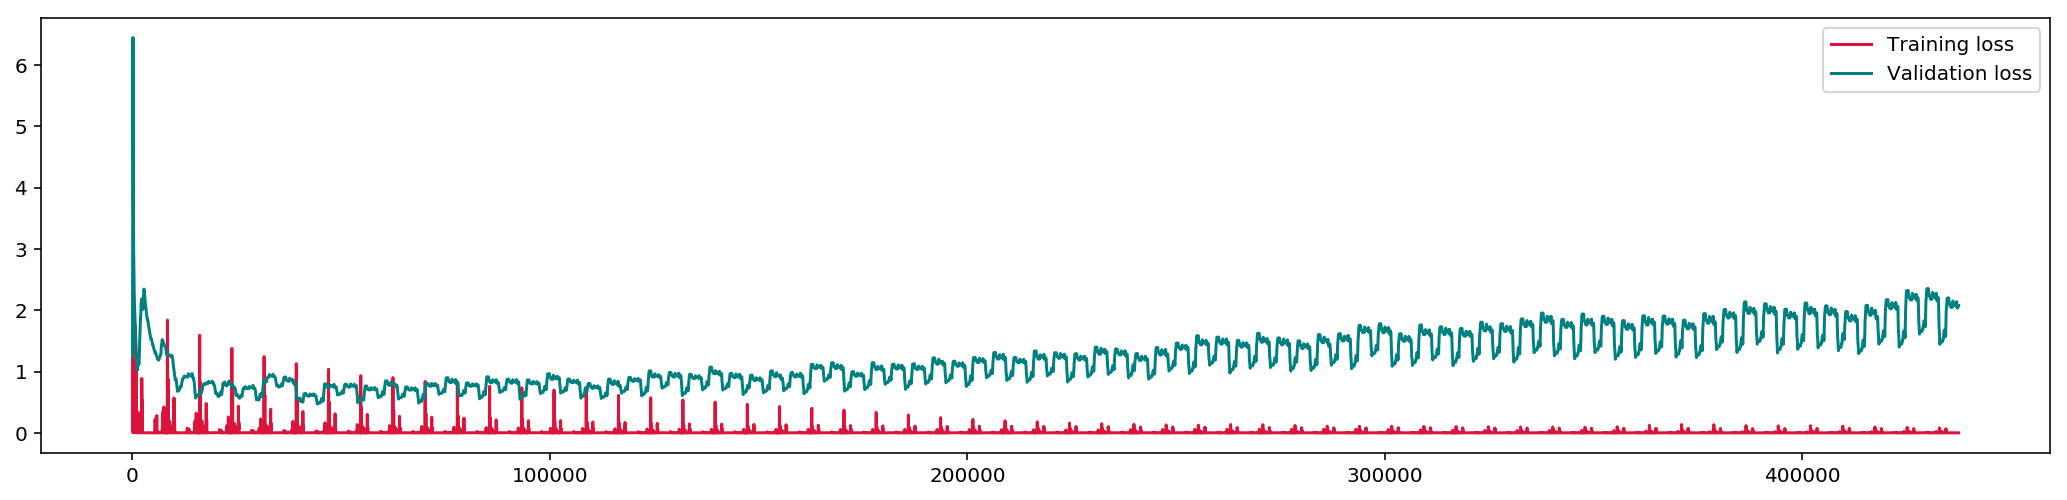

In [34]:
# Plot the smoothed training and validation loss


smoothed_loss = hm.running_mean(losses['train'], 50)
smoothed_loss_train = hm.running_mean(losses['validation'], 8000)

fig = plt.figure(figsize=(18,4))
gs  = gridspec.GridSpec(1, 2, height_ratios=[1],width_ratios=[0.5,0.5])
ax1 = plt.subplot(gs[0, 0:2])

ax1.plot(smoothed_loss, label='Training loss', color='crimson')
ax1.plot(smoothed_loss_train, label='Validation loss', color='teal')
ax1.legend()

plt.show()

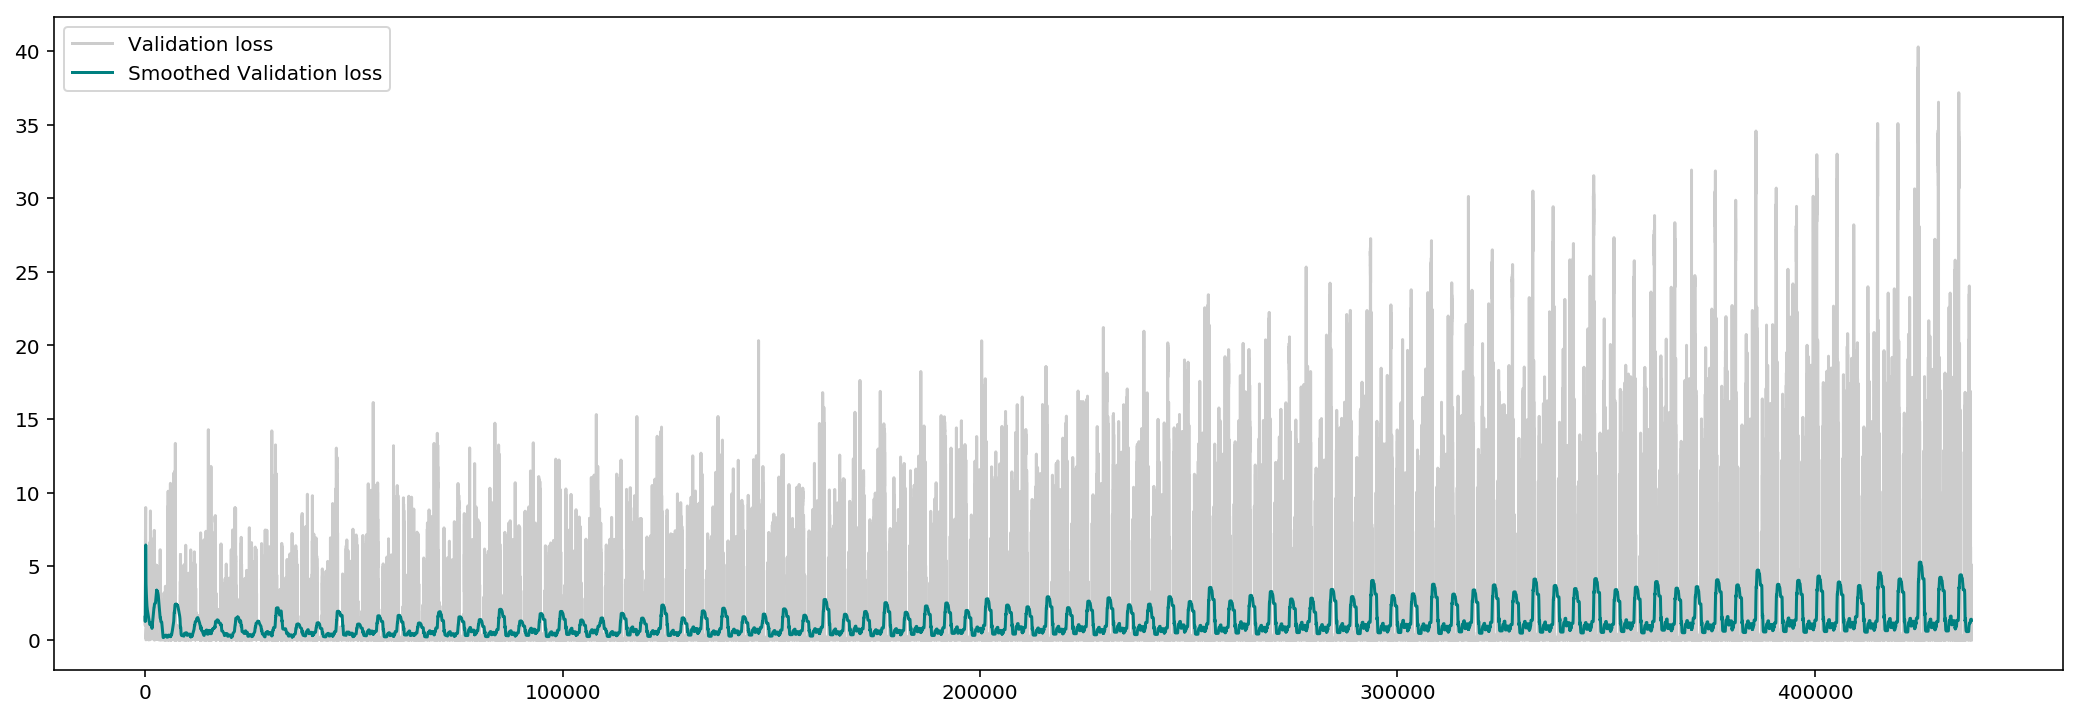

In [35]:
# Plot the smoothed and raw validation loss

non_smoothed_loss_train = hm.running_mean(losses['validation'], 1)
smoothed_loss_train = hm.running_mean(losses['validation'], 1500)

fig = plt.figure(figsize=(18,6))
gs  = gridspec.GridSpec(1, 2, height_ratios=[1],width_ratios=[0.5,0.5])
ax1 = plt.subplot(gs[0, 0:2])

ax1.plot(non_smoothed_loss_train, label='Validation loss', color='gray', alpha=0.4)
ax1.plot(smoothed_loss_train, label='Smoothed Validation loss', color='teal')
ax1.legend()
#plt.ylim([-0.2,3.5])
plt.show()

fig.savefig('validloss.pdf')

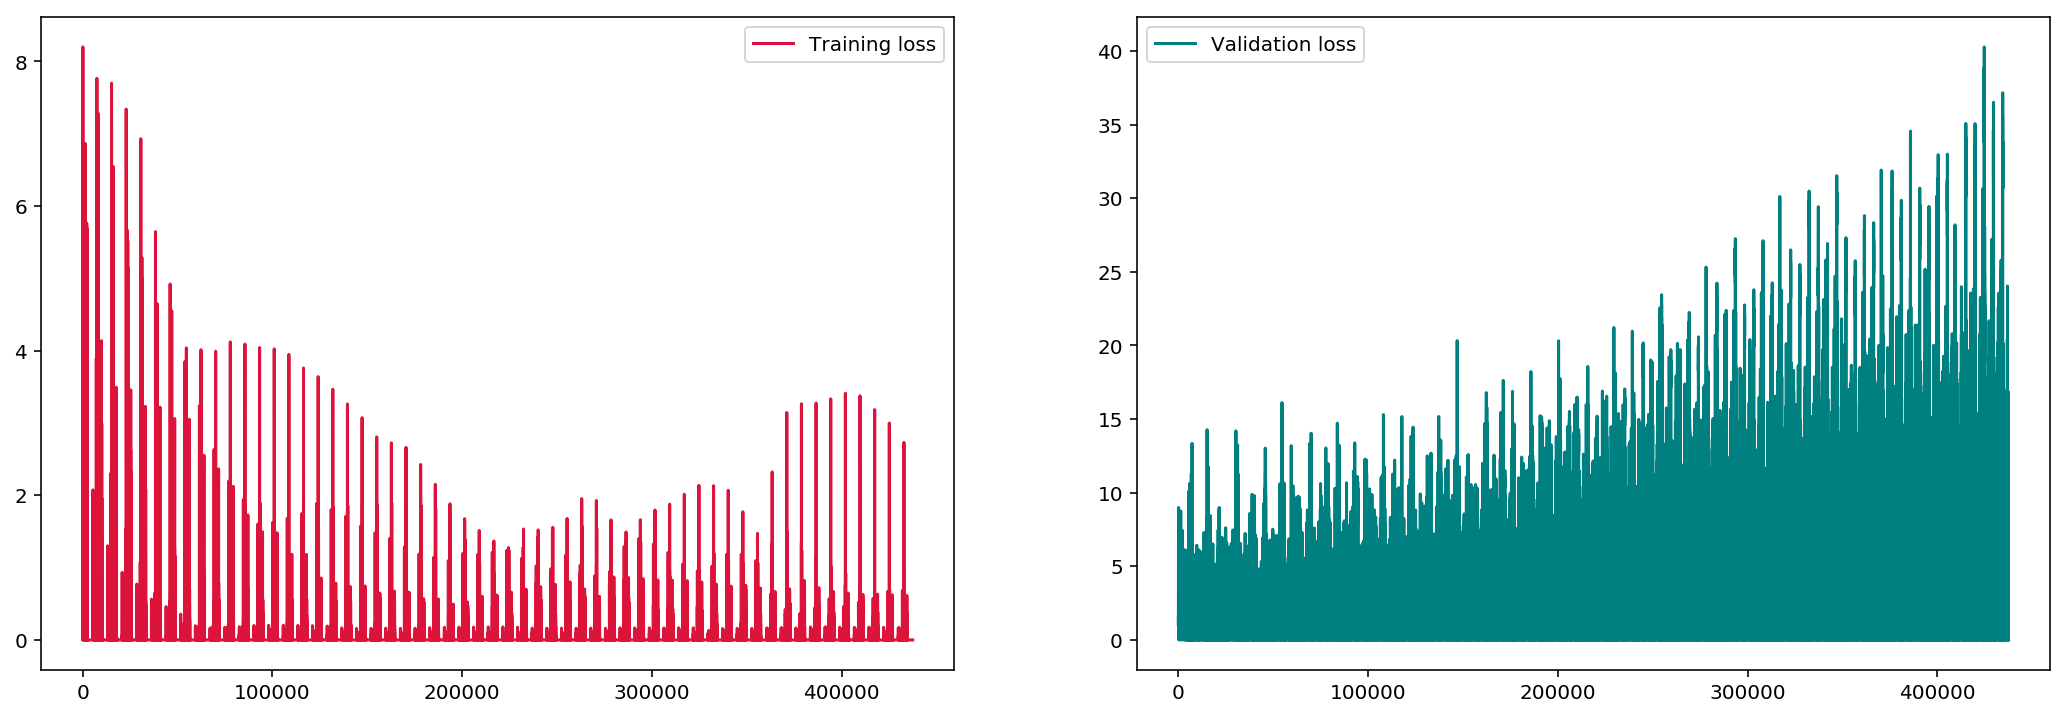

In [36]:
# Plot training and validation loss

fig = plt.figure(figsize=(18,6))
gs  = gridspec.GridSpec(1, 2, height_ratios=[1],width_ratios=[0.5,0.5])
ax1 = plt.subplot(gs[0, 0:1])
ax2 = plt.subplot(gs[0, 1:])

ax1.plot(losses['train'], label='Training loss', color='crimson')
ax2.plot(losses['validation'], label='Validation loss', color='teal')
ax1.legend()
ax2.legend()

plt.show()


fig.savefig('trainvalidloss.pdf')

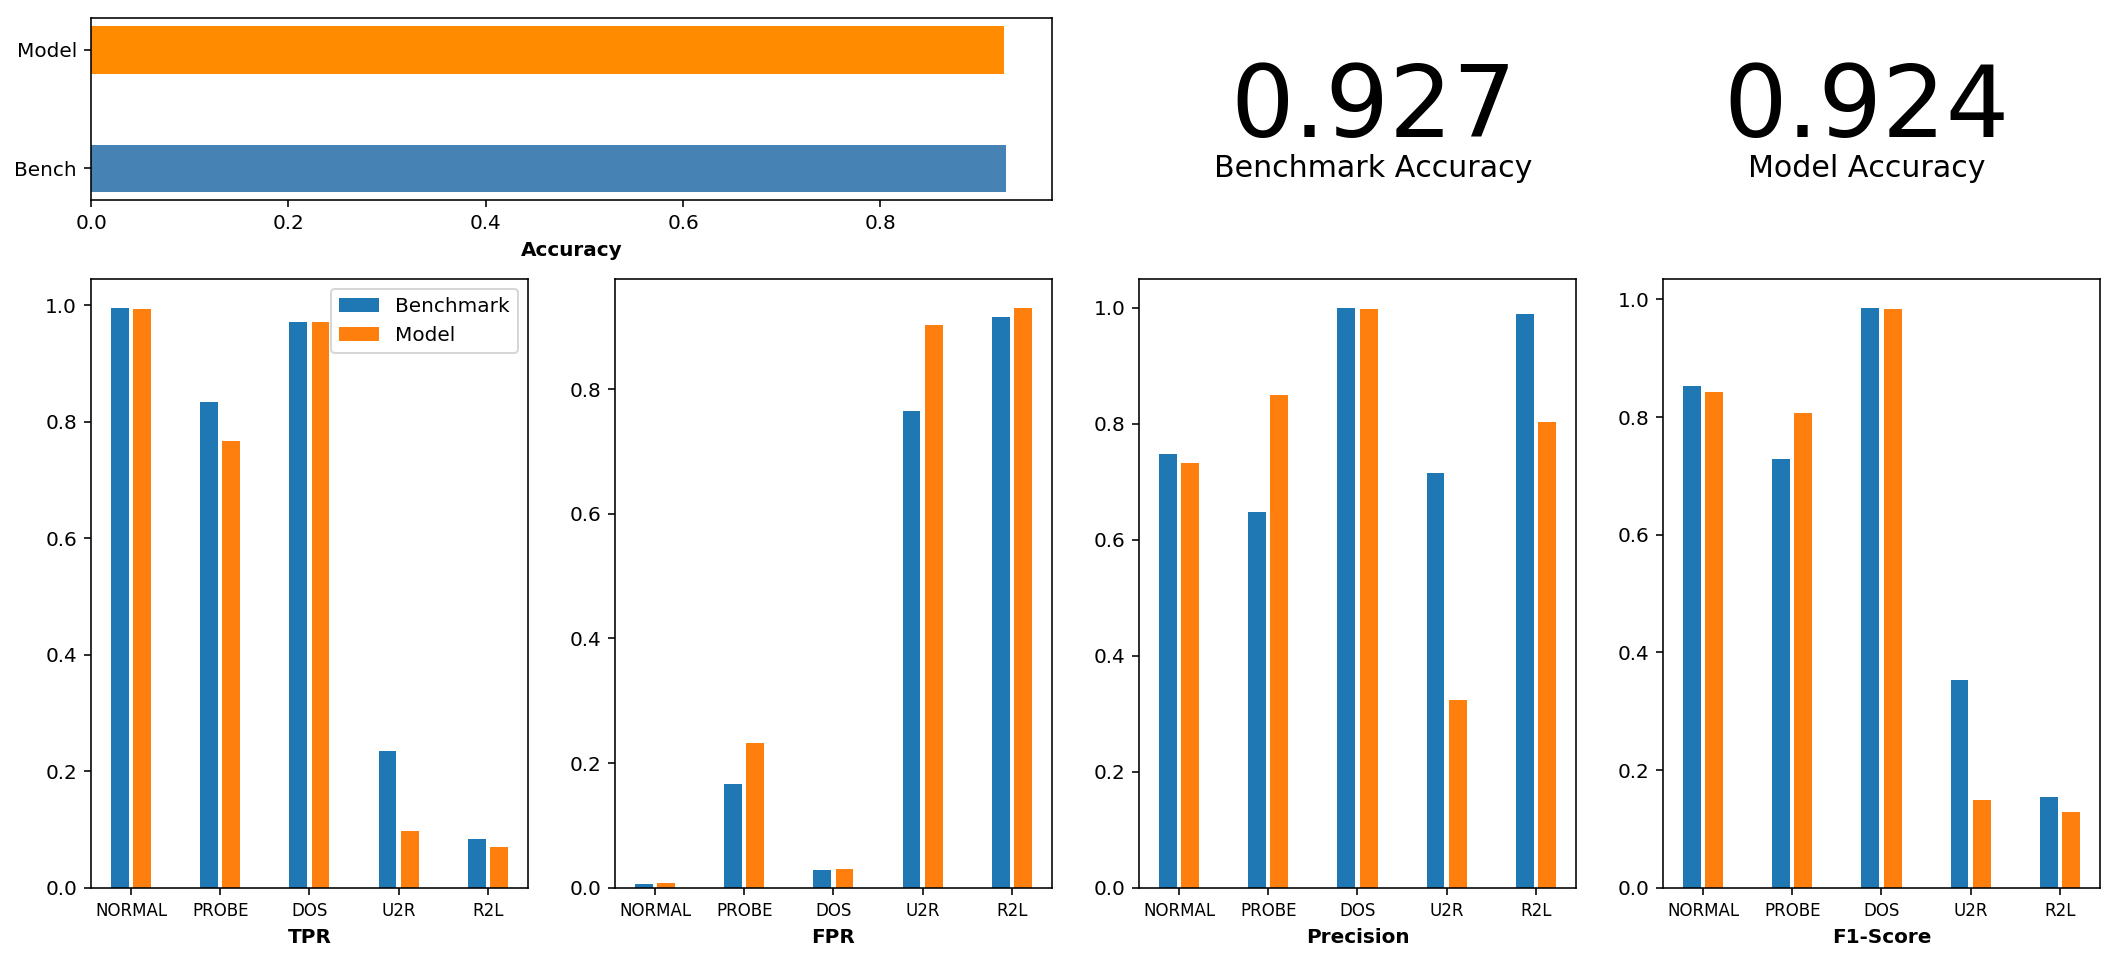

In [37]:
# Show the evaluation metrics

conf_bench = hm.getBenchmarkResults()
metrics = hm.computePerformanceMetrics(conf_bench, conf_matrix)
fig = hm.plotMetrics(metrics)

fig.savefig('results.pdf')